# EXPERIMENT SETUP #3 - Model
Now that we have made decision based on the results of previous experiments, lets see how much we can tweak on the model and see what it can do.

From what I understand BERT is a very complicated text encoder. That means BERT is just the starting peice for many NLP tasks. The way I tought myself is that BERT is a much more complex and general word2vec model. Now when you have to do some NLP task with word2vec, you take the embeddings from word2vec and then use that to train another model.

I have planned to apply the same logic here.

Using the BERT as a featurizer and then putting a classifier DNN after it. Since we are working with sentences I was interetested to know if a classifier with an LSTM layer would add any value or if it will only to the complexity.

## Load Data

In [1]:
!pip install transformers nltk

     |████████████████████████████████| 2.1MB 6.5MB/s 
     |████████████████████████████████| 3.3MB 30.1MB/s 
     |████████████████████████████████| 901kB 27.9MB/s 


In [2]:
import pandas as pd
%matplotlib inline
import numpy as np
import tensorflow as tf
from google.colab import drive
import os
import bert
import trainer
import utils
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import json

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

In [3]:
drive.mount('/gdrive')
os.listdir('/gdrive/MyDrive/data')

Mounted at /gdrive


['train.csv',
 'saved_models',
 'tokenizer_exp',
 'val.csv',
 'data.csv',
 'model_exp']

In [4]:
dataset_location = '/gdrive/MyDrive/data'
path = "/gdrive/MyDrive/data/model_exp"
use_tpu = True
train = True

In [5]:
if not os.path.exists(path):
    os.mkdir(path)

In [6]:
dataset = pd.read_csv("{}/data.csv".format(dataset_location))
validation_dataset = pd.read_csv("{}/val.csv".format(dataset_location))

In [7]:
dataset.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,10,$\mathcal{R}_{0}$ fails to predict the outbrea...,Time varying susceptibility of host at indiv...,0,0,0,0,1,0
1,21,Deciphering noise amplification and reduction ...,The impact of random fluctuations on the dyn...,0,0,0,0,1,0
2,34,An Unsupervised Homogenization Pipeline for Cl...,Electronic health records (EHR) contain a la...,0,0,0,0,1,0
3,42,Are multi-factor Gaussian term structure model...,"In this paper, we empirically study models f...",0,0,0,0,0,1
4,56,Competing evolutionary paths in growing popula...,Investigating the emergence of a particular ...,0,0,0,0,1,0


In [8]:
dataset["text"] = dataset["TITLE"] + " ." + dataset["ABSTRACT"]
validation_dataset["text"] = validation_dataset["TITLE"] + " ." + validation_dataset["ABSTRACT"]
dataset.head(1)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text
0,10,$\mathcal{R}_{0}$ fails to predict the outbrea...,Time varying susceptibility of host at indiv...,0,0,0,0,1,0,$\mathcal{R}_{0}$ fails to predict the outbrea...


In [9]:
classes = ["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology", "Quantitative Finance"]

In [10]:
Y = dataset[classes].values
Y_val = validation_dataset[classes].values

In [11]:
if use_tpu:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    except ValueError:
        strategy = tf.distribute.get_strategy() # for CPU and single GPU
        print('Number of replicas:', strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.19.5.218:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.19.5.218:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## Train

In [12]:
class ModelConfig:
    max_length = 200
    bert_name = "bert-base-uncased"
    num_labels = 6
    optimizer = tf.keras.optimizers.Adam(0.00001)
    loss_function = "binary_crossentropy"
    metrics = ["accuracy"]


class TrainerConfig:
    test_size = 0.2
    fold_count = 8
    batch_size = 64
    epochs = 10

### First Model
The first model is our base line model that just use the BertForSequenceClassification from the transformers module.

In [ ]:
processors = [utils.replace_latex_math_with, utils.to_corpus, utils.lemmatize_sentence]
version = "1"
if use_tpu:
    with strategy.scope():
        model = bert.SimpleBertForSequenceClassification(config=ModelConfig)
        model.version = version
        model.build(processors=processors)
else:
    model = bert.SimpleBertForSequenceClassification(config=ModelConfig)
    model.version = version
    model.build(processors=processors)
if train:
    trainer_methodology = trainer.TestTrainSplitTrainer(config=TrainerConfig, model=model)
    trainer_methodology.initialize(x=dataset["text"], y=Y)
    training_history = trainer_methodology.train()
    training_history = utils.training_history_to_dict(training_history)
    with open(os.path.join(path, "training_results_{}.json".format(model.name())), "w") as file:
        json.dump(training_history, file)
    model.save(path)
else:
    model.load(path)
    with open(os.path.join(path, "training_results_{}.json".format(model.name())), "w") as file:
        training_history = json.load(file) 

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


250/250 [==============================] - ETA: 0s - loss: 0.6003 - accuracy: 0.4673WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


250/250 [==============================] - 214s 362ms/step - loss: 0.5996 - accuracy: 0.4678 - val_loss: 0.2593 - val_accuracy: 0.7617
Epoch 2/10
250/250 [==============================] - 35s 138ms/step - loss: 0.3451 - accuracy: 0.6896 - val_loss: 0.3341 - val_accuracy: 0.6723
Epoch 3/10
250/250 [==============================] - 35s 139ms/step - loss: 0.3055 - accuracy: 0.7047 - val_loss: 0.2427 - val_accuracy: 0.7429
Epoch 4/10
250/250 [==============================] - 34s 138ms/step - loss: 0.2589 - accuracy: 0.7440 - val_loss: 0.2274 - val_accuracy: 0.7334
Epoch 5/10
250/250 [==============================] - 35s 138ms/step - loss: 0.2346 - accuracy: 0.7528 - val_loss: 0.2235 - val_accuracy: 0.7116
Epoch 6/10
250/250 [==============================] - 35s 140ms/step - loss: 0.2204 - accuracy: 0.7622 - val_loss: 0.2263 - val_accuracy: 0.7161
Epoch 7/10
250/250 [==============================] - 35s 139ms/step - loss: 0.2240 - accuracy: 0.7448 - val_loss: 0.2193 - val_accuracy: 0.

### Second Model
The second model is slightly different in the sense that input nodes are passing to the BertModel of transformers and the output of the BertModel is passed to a dense layer. This should is theory work similar to BertForSequenceClassification. The following is the code used to build the model

```python
    def build(self, processors=None):
        if processors is None:
            processors = []
        self.tokenizer = BertTokenizer.from_pretrained(self.config.bert_name)
        self.data_processor = self.build_data_processor(processors=processors)
        bert = TFBertModel.from_pretrained(self.config.bert_name)

        input_ids = tf.keras.layers.Input(shape=(self.config.max_length,), name='input_ids', dtype='int32')
        input_type = tf.keras.layers.Input(shape=(self.config.max_length,), name='token_type_ids', dtype='int32')
        mask = tf.keras.layers.Input(shape=(self.config.max_length,), name='attention_mask', dtype='int32')

        embeddings = bert([input_ids, mask, input_type])[0]

        y = tf.keras.layers.Dense(self.config.num_labels, activation='sigmoid', name='outputs')(embeddings[:, 0, :])

        self.model = tf.keras.Model(inputs=[input_ids, input_type, mask], outputs=y)

        self.model.compile(optimizer=self.config.optimizer, loss=self.config.loss_function, metrics=self.config.metrics)
        return self
```

In [ ]:
processors = [utils.replace_latex_math_with, utils.to_corpus, utils.lemmatize_sentence]
version = "1"
if use_tpu:
    with strategy.scope():
        model = bert.BertToSingleLayerNeuralNetwork(config=ModelConfig)
        model.version = version
        model.build(processors=processors)
else:
    model = bert.BertToSingleLayerNeuralNetwork(config=ModelConfig)
    model.version = version
    model.build(processors=processors)
if train:
    trainer_methodology = trainer.TestTrainSplitTrainer(config=TrainerConfig, model=model)
    trainer_methodology.initialize(x=dataset["text"], y=Y)
    training_history = trainer_methodology.train()
    training_history = utils.training_history_to_dict(training_history)
    with open(os.path.join(path, "training_results_{}.json".format(model.name())), "w") as file:
        json.dump(training_history, file)
    model.save(path)
else:
    model.load(path)
    with open(os.path.join(path, "training_results_{}.json".format(model.name())), "w") as file:
        training_history = json.load(file) 

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/10


250/250 [==============================] - ETA: 0s - loss: 0.2581 - accuracy: 0.7017WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


250/250 [==============================] - 171s 365ms/step - loss: 0.2579 - accuracy: 0.7019 - val_loss: 0.1658 - val_accuracy: 0.7620
Epoch 2/10
250/250 [==============================] - 35s 140ms/step - loss: 0.1494 - accuracy: 0.7862 - val_loss: 0.1657 - val_accuracy: 0.7492
Epoch 3/10
250/250 [==============================] - 35s 140ms/step - loss: 0.1264 - accuracy: 0.8054 - val_loss: 0.1681 - val_accuracy: 0.7665
Epoch 4/10
250/250 [==============================] - 36s 143ms/step - loss: 0.1013 - accuracy: 0.8240 - val_loss: 0.1826 - val_accuracy: 0.7777
Epoch 5/10
250/250 [==============================] - 35s 140ms/step - loss: 0.0813 - accuracy: 0.8381 - val_loss: 0.2010 - val_accuracy: 0.7642
Epoch 6/10
250/250 [==============================] - 35s 139ms/step - loss: 0.0636 - accuracy: 0.8493 - val_loss: 0.2263 - val_accuracy: 0.7607
Epoch 7/10
250/250 [==============================] - 35s 139ms/step - loss: 0.0485 - accuracy: 0.8533 - val_loss: 0.2509 - val_accuracy: 0.

### Third Model
The third variation is very similar to the second model but the output of BERT model is passed to an LSTM layer before a couple of dense layers and a dropout layer to restrict overfitting.
The idea of using an LSTM is that since we are working with text which has a sequential nature, LSTM might be able to perform better. Following is the code to build the model.

```python
    def build(self, processors=None):
        if processors is None:
            processors = []
        self.tokenizer = BertTokenizer.from_pretrained(self.config.bert_name)
        self.data_processor = self.build_data_processor(processors=processors)
        bert = TFBertModel.from_pretrained(self.config.bert_name)

        input_ids = tf.keras.layers.Input(shape=(self.config.max_length,), name='input_ids', dtype='int32')
        input_type = tf.keras.layers.Input(shape=(self.config.max_length,), name='token_type_ids', dtype='int32')
        mask = tf.keras.layers.Input(shape=(self.config.max_length,), name='attention_mask', dtype='int32')

        embeddings = bert([input_ids, mask, input_type])[0]

        x = tf.keras.layers.LSTM(128)(embeddings)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        x = tf.keras.layers.Dense(32, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.01)(x)
        y = tf.keras.layers.Dense(self.config.num_labels, activation='sigmoid', name='outputs')(x)

        self.model = tf.keras.Model(inputs=[input_ids, input_type, mask], outputs=y)

        self.model.compile(optimizer=self.config.optimizer, loss=self.config.loss_function, metrics=self.config.metrics)
        return self
```

In [ ]:
processors = [utils.replace_latex_math_with, utils.to_corpus, utils.lemmatize_sentence]
version = "1"
if use_tpu:
    with strategy.scope():
        model = bert.BertWithLSTM(config=ModelConfig)
        model.version = version
        model.build(processors=processors)
else:
    model = bert.BertWithLSTM(config=ModelConfig)
    model.version = version
    model.build(processors=processors)
if train:
    trainer_methodology = trainer.TestTrainSplitTrainer(config=TrainerConfig, model=model)
    trainer_methodology.initialize(x=dataset["text"], y=Y)
    training_history = trainer_methodology.train()
    training_history = utils.training_history_to_dict(training_history)
    with open(os.path.join(path, "training_results_{}.json".format(model.name())), "w") as file:
        json.dump(training_history, file)
    model.save(path)
else:
    model.load(path)
    with open(os.path.join(path, "training_results_{}.json".format(model.name())), "w") as file:
        training_history = json.load(file) 

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/10


250/250 [==============================] - ETA: 0s - loss: 0.3891 - accuracy: 0.6664WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


250/250 [==============================] - 181s 394ms/step - loss: 0.3888 - accuracy: 0.6667 - val_loss: 0.2451 - val_accuracy: 0.7394
Epoch 2/10
250/250 [==============================] - 38s 153ms/step - loss: 0.2262 - accuracy: 0.7705 - val_loss: 0.1887 - val_accuracy: 0.7352
Epoch 3/10
250/250 [==============================] - 39s 154ms/step - loss: 0.1932 - accuracy: 0.7933 - val_loss: 0.1844 - val_accuracy: 0.7399
Epoch 4/10
250/250 [==============================] - 38s 150ms/step - loss: 0.1695 - accuracy: 0.8003 - val_loss: 0.1798 - val_accuracy: 0.7519
Epoch 5/10
250/250 [==============================] - 38s 150ms/step - loss: 0.1519 - accuracy: 0.8080 - val_loss: 0.1841 - val_accuracy: 0.7577
Epoch 6/10
250/250 [==============================] - 37s 150ms/step - loss: 0.1383 - accuracy: 0.8160 - val_loss: 0.1929 - val_accuracy: 0.7389
Epoch 7/10
250/250 [==============================] - 37s 150ms/step - loss: 0.1210 - accuracy: 0.8283 - val_loss: 0.1998 - val_accuracy: 0.

## Evaluate

In [13]:
exp_names = ["Bert for sequence classification from Transformers", "Bert to a dense layer", "Bert to an LSTM"]

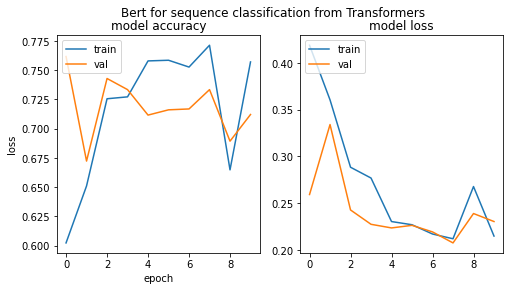

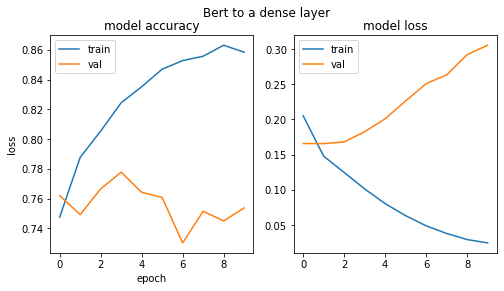

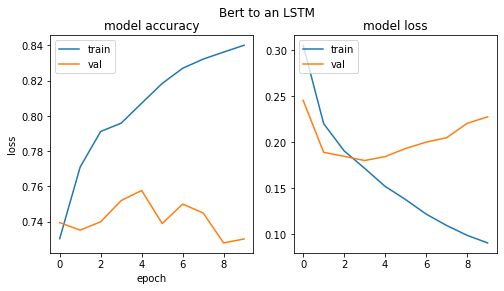

In [14]:
model = bert.SimpleBertForSequenceClassification(config=ModelConfig)
model.version = "1"
with open(os.path.join(path, "training_results_{}.json".format(model.name())), "r") as file:
    training_history = json.load(file)
utils.plot_training_result(training_history, exp_names[0])

model = bert.BertToSingleLayerNeuralNetwork(config=ModelConfig)
model.version = "1"
with open(os.path.join(path, "training_results_{}.json".format(model.name())), "r") as file:
    training_history = json.load(file)
utils.plot_training_result(training_history, exp_names[1])

model = bert.BertWithLSTM(config=ModelConfig)
model.version = "1"
with open(os.path.join(path, "training_results_{}.json".format(model.name())), "r") as file:
    training_history = json.load(file)
utils.plot_training_result(training_history, exp_names[2])

From the training graph, the performance jump moving to Bert to dense layer is considerable. Even though there are signs of overfitting, the results looks promising enough. The overfitting problem can verified using the validation dataset and see what kind of performance differnce each model gives on the validation dataset.

Multiple runs is needed to reduce the effects of randomness, but with the data we have the second and third model has a definite impact in the performance. The second and third model are very close and multiple runs might be able to tell a better story.

In [16]:
model = bert.SimpleBertForSequenceClassification(config=ModelConfig)
model.build(processors=[utils.replace_latex_math_with, utils.to_corpus, utils.lemmatize_sentence])
model.version = "1"
model.load(path)
simple_y_pred = model.predict(validation_dataset["text"])

model = bert.BertToSingleLayerNeuralNetwork(config=ModelConfig)
model.build(processors=[utils.replace_latex_math_with, utils.to_corpus, utils.lemmatize_sentence])
model.version = "1"
model.load(path)
dense_y_pred = model.predict(validation_dataset["text"])

model = bert.BertWithLSTM(config=ModelConfig)
model.build(processors=[utils.replace_latex_math_with, utils.to_corpus, utils.lemmatize_sentence])
model.version = "1"
model.load(path)
lstm_y_pred = model.predict(validation_dataset["text"])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from th

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [17]:
y_preds=[simple_y_pred, dense_y_pred, lstm_y_pred]
Ys=[Y_val, Y_val, Y_val]
classes=classes
threshold=0.5
model_names=exp_names

In [18]:
utils.print_f1_scores(y_preds, Ys, classes, threshold, model_names)

F1-Score for is  Bert for sequence classification from Transformers : [('Computer Science', 0.4622222222222222), ('Physics', 0.32222222222222224), ('Mathematics', 0.317948717948718), ('Statistics', 0.43262001156738), ('Quantitative Biology', 0.9101214574898785), ('Quantitative Finance', 0.8471001757469245)]
F1-Score for is  Bert to a dense layer : [('Computer Science', 0.8187372708757638), ('Physics', 0.8773109243697479), ('Mathematics', 0.7992957746478874), ('Statistics', 0.8093385214007782), ('Quantitative Biology', 0.9281867145421903), ('Quantitative Finance', 0.9567010309278351)]
F1-Score for is  Bert to an LSTM : [('Computer Science', 0.7962382445141065), ('Physics', 0.8665568369028007), ('Mathematics', 0.7944732297063902), ('Statistics', 0.7799999999999999), ('Quantitative Biology', 0.874296435272045), ('Quantitative Finance', 0.9386892177589852)]


Here we see a very clear difference in the performance between the first and secodn and third model. The first model clearly is struggling to fit. The second and third model seems to be neck and neck.

In [19]:
utils.print_hamming_losses(y_preds, Ys, classes, threshold, model_names)

Hamming for Bert for sequence classification from Transformers  :  0.42832327665021025
Hamming for Bert to a dense layer  :  0.056043152313037116
Hamming for Bert to an LSTM  :  0.06710550374840007


The story is further validated by the hamming losses, the jump in performance from first to second model is considerable. But the difference in the second and third is very minimal.

Confusion matrix for Bert for sequence classification from Transformers


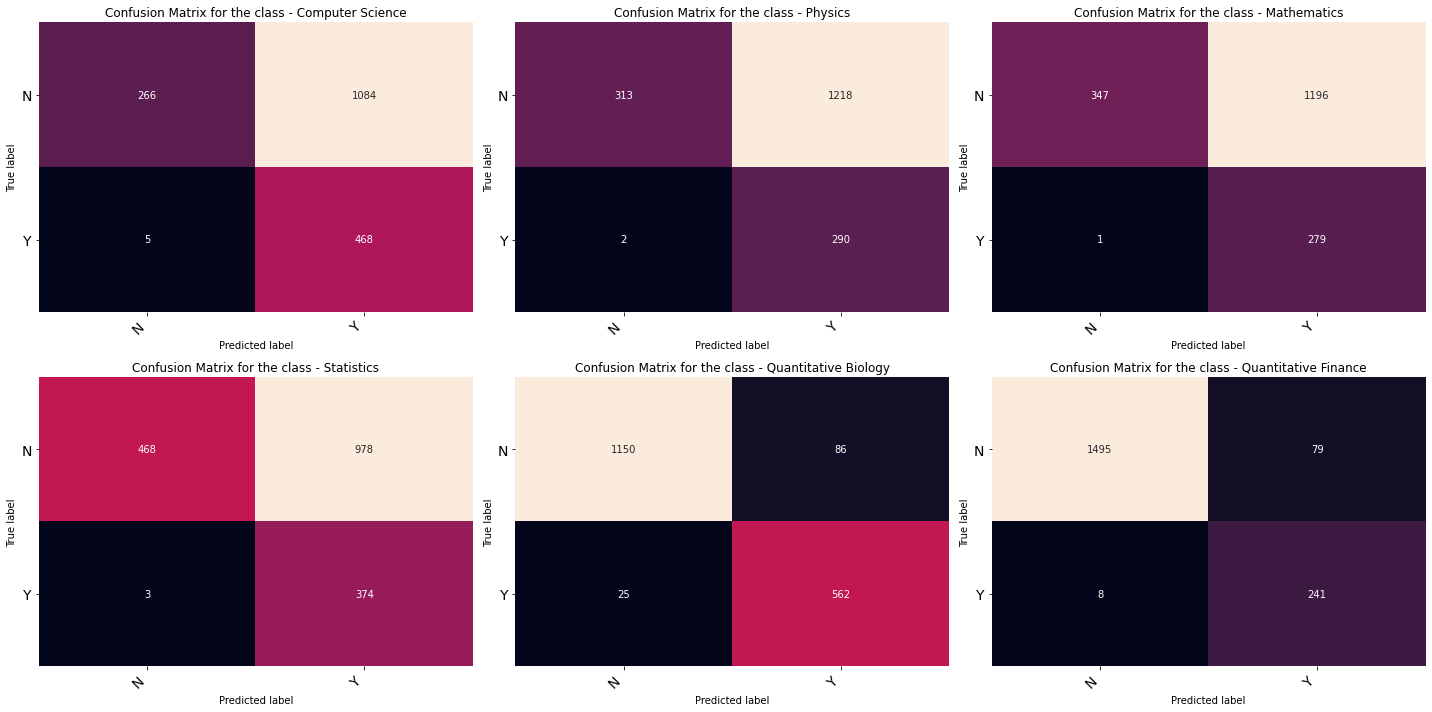

Confusion matrix for Bert to a dense layer


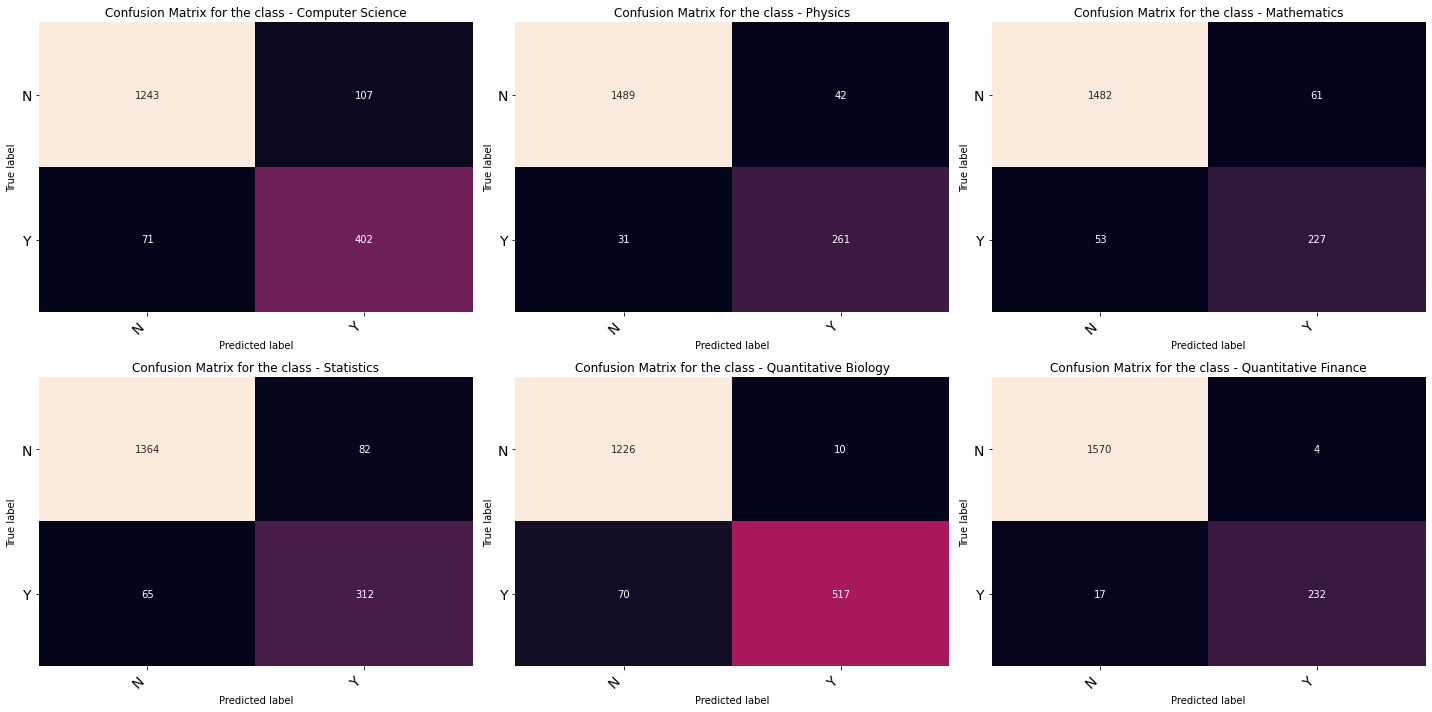

Confusion matrix for Bert to an LSTM


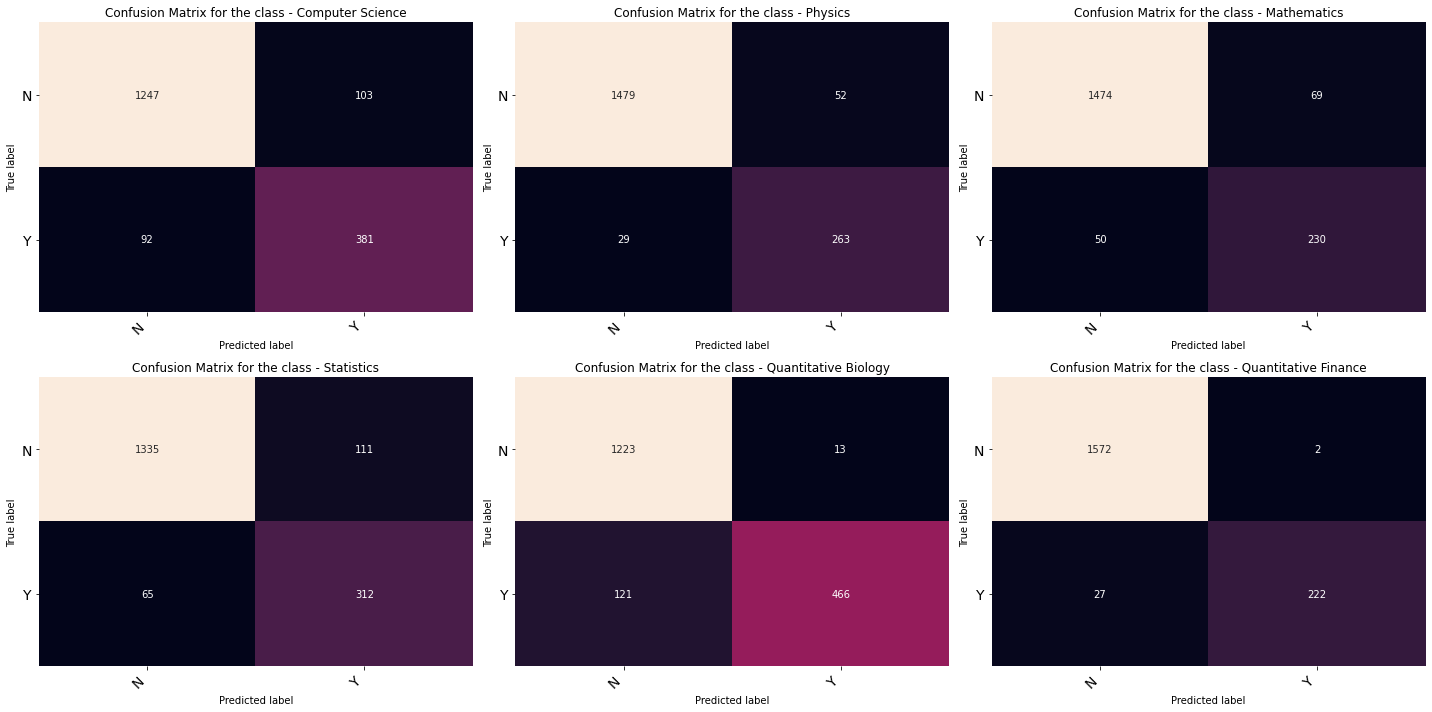

In [20]:
utils.draw_confusion_matrices(y_preds, Ys, classes, threshold, model_names)

ROC curve for Bert for sequence classification from Transformers


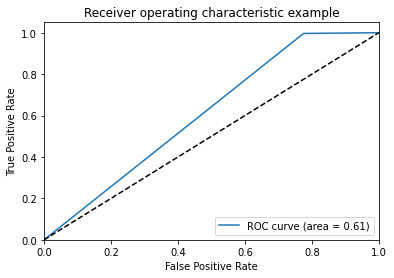

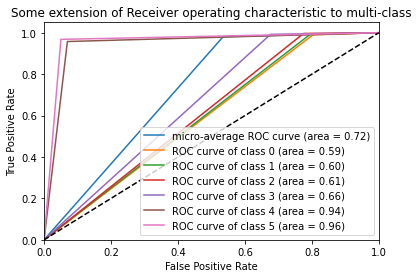

ROC curve for Bert to a dense layer


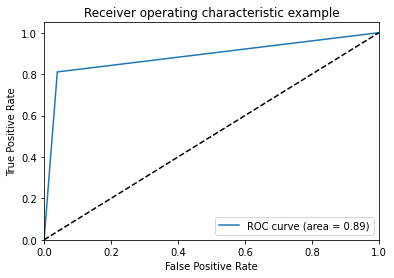

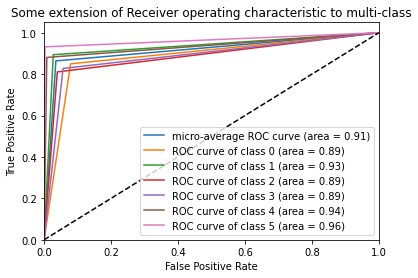

ROC curve for Bert to an LSTM


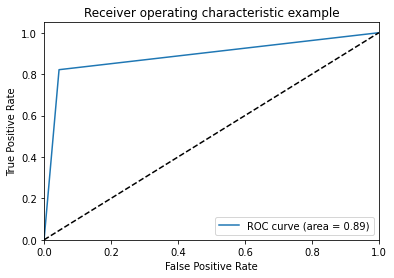

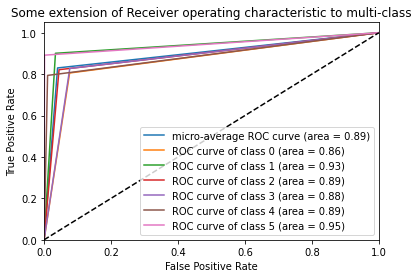

In [21]:
utils.draw_rocs(y_preds, Ys, classes, threshold, model_names)

In [22]:
utils.print_classification_reports(y_preds, Ys, classes, threshold, model_names)

Classification for Bert for sequence classification from Transformers  : 
                       precision    recall  f1-score   support

    Computer Science       0.30      0.99      0.46       473
             Physics       0.19      0.99      0.32       292
         Mathematics       0.19      1.00      0.32       280
          Statistics       0.28      0.99      0.43       377
Quantitative Biology       0.87      0.96      0.91       587
Quantitative Finance       0.75      0.97      0.85       249

           micro avg       0.32      0.98      0.49      2258
           macro avg       0.43      0.98      0.55      2258
        weighted avg       0.47      0.98      0.58      2258
         samples avg       0.38      0.98      0.52      2258

Classification for Bert to a dense layer  : 
                       precision    recall  f1-score   support

    Computer Science       0.79      0.85      0.82       473
             Physics       0.86      0.89      0.88       292
       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Conclusion
From the experiments, it can be seen that the vanilla BertForSequenceClassification is outperformed by Bert connected to a Dense layer and a Bert connect to an LSTM.

However, the difference between Bert to Dense and Bert to LSTM is not significant enought to justify it. It is always better to choose a simpler architecture over a complicated one in the real world when you consider training and inference time.

And that has driven the choice in this project. Further experiments will be based on Bert To Dense layer model.